# Capacity allocation

## 0. Load libraries

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import shutil

from functools import reduce
from mealpy import IntegerVar
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.physics_based import SA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from operator import mul
from pathlib import Path

from benchmarks.generator import get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart

from robin.supply.saver.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply
from src.entities import Solution
from src.timetabling_problem import MPTT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Config files
supply_config_path = Path("../../configs/generator/supply_config.yml")
demand_config_path = Path("../../configs/demand/demand.yml")
generator_config_path = Path("../../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../../data/generator/supply_dummy.yml')
supply_save_path = '../../configs/mealpy/'
robin_save_path = '../../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

In [21]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [22]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [23]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


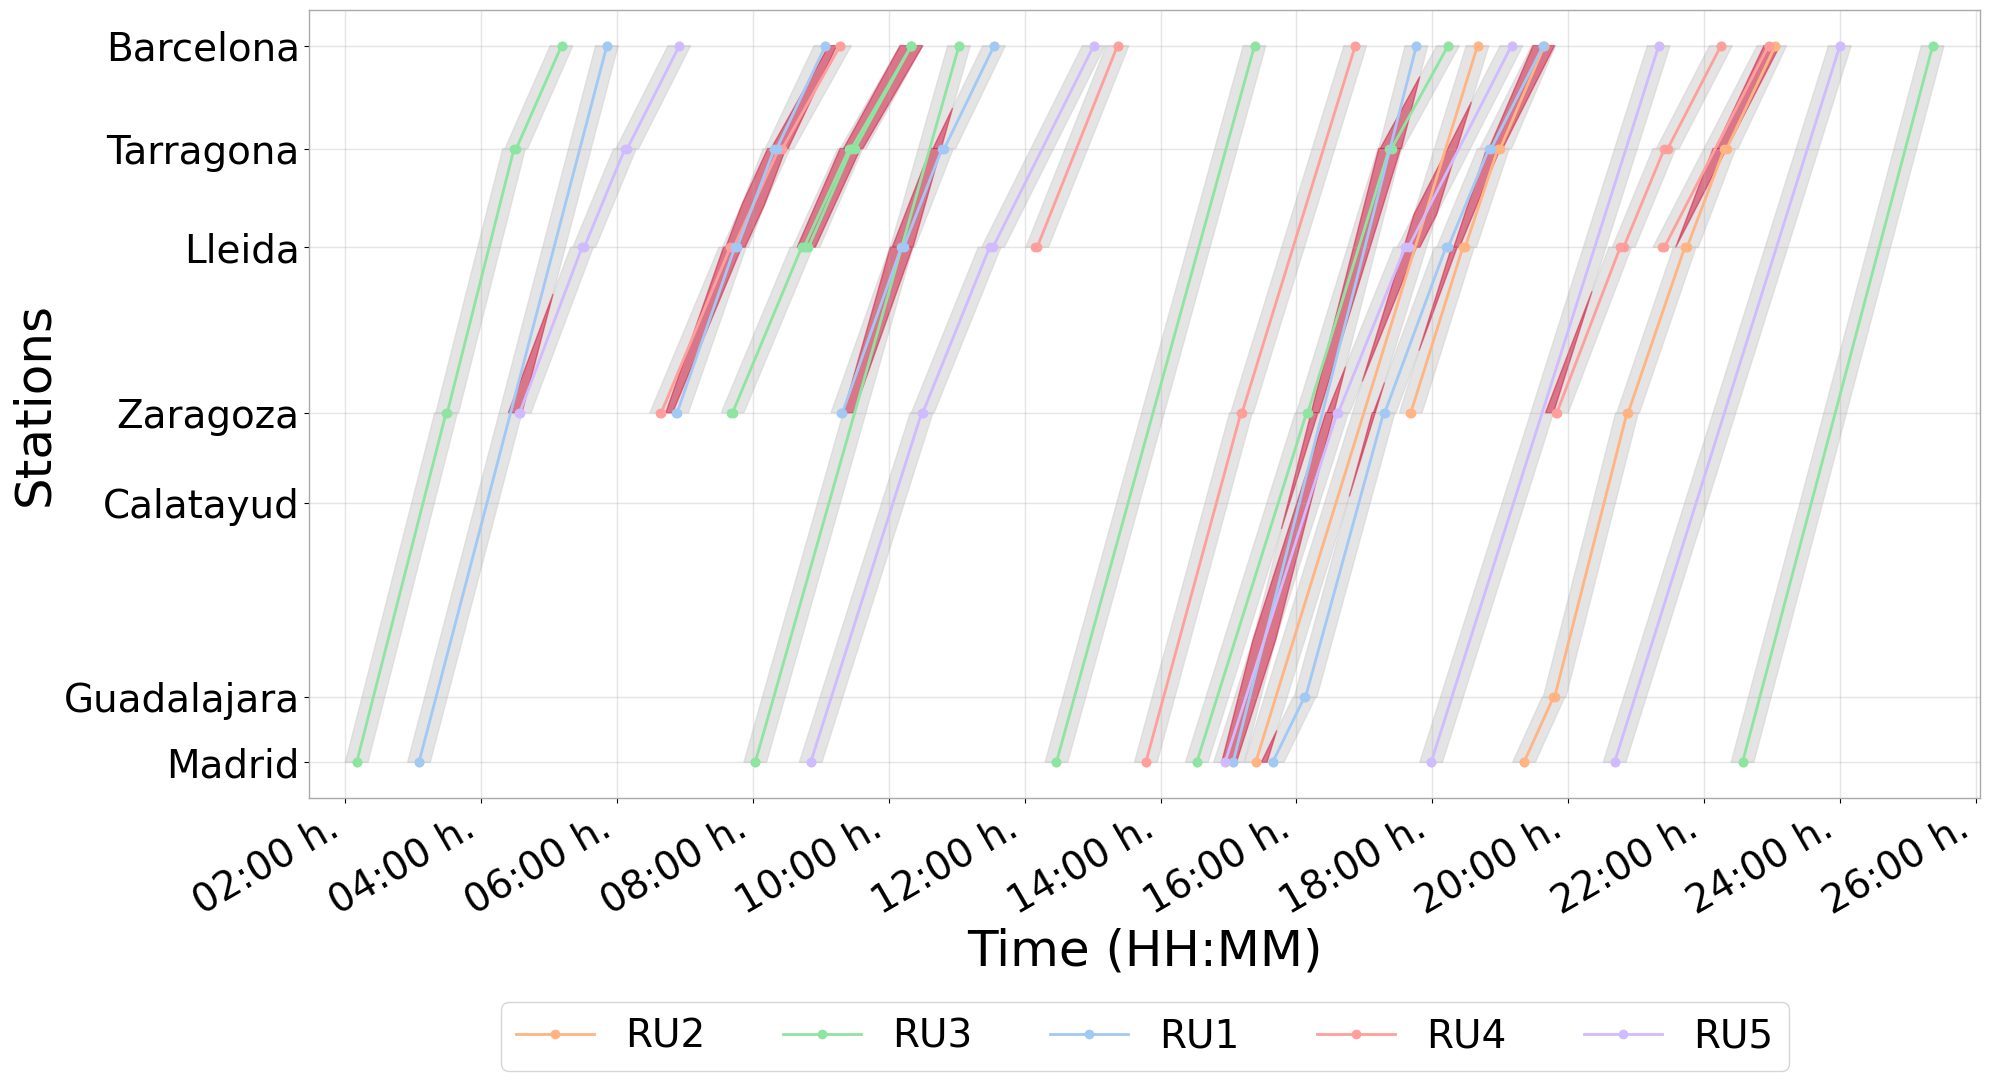

In [24]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/'
)

## 1. Mealpy

In [25]:
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

In [26]:
mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [27]:
opti_params = {"Genetic Algorithm": {"epoch": 500, "pop_size": 70},
               "Particle Swarm Optimization": {"epoch": 500, "pop_size": 80},
               "Simulated Annealing": {"epoch": 500, "pop_size": 90},
               "Differential Evolution": {"epoch": 300, "pop_size": 100},
               "Ant Colony Optimization Continuous (ACOR)": {"epoch": 500, "pop_size": 10},
               "Covariance Matrix Adaptation Evolution Strategy": {"epoch": 250, "pop_size": 80},
               "Artificial Bee Colony": {"epoch": 450, "pop_size": 60},
               "Grey Wolf Optimizer": {"epoch": 500, "pop_size": 100},
               "Whale Optimization Algorithm": {"epoch": 400, "pop_size": 80},
               "Hybrid Grey Wolf - Whale Optimization Algorithm": {"epoch": 450, "pop_size": 50}
               }

In [ ]:
import os

max_pop_size = max([opti_params[algo]["pop_size"] for algo in opti_params])

runs = 5
seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# Configuración de archivos CSV
history_csv = 'history_results.csv'
population_csv = 'population_results.csv'

# Crear archivos CSV con encabezados si no existen
if not os.path.exists(history_csv):
    pd.DataFrame(columns=['Run', 'Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 
                          'Real', 'Diversity', 'Exploitation', 'Exploration']
                 ).to_csv(history_csv, sep=';', index=False)

if not os.path.exists(population_csv):
    population_columns = ['Run', 'Algo', 'Iteration'] + \
                         [f'real_{i}' for i in range(max_pop_size)] + \
                         [f'discrete_{i}' for i in range(max_pop_size)]
    pd.DataFrame(columns=population_columns).to_csv(population_csv, sep=';' , index=False)

# Ejecución principal
for algo_name, algo in mp_algos.items():
    
    # Re-inicializar semilla
    np.random.seed(seed_initializer)
    
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        run_seed = np.random.randint(0, 1000)
        
        # Ejecutar algoritmo
        if algo_name == "Simulated Annealing":
            optimizer = algo(reduce(mul, opti_params[algo_name].values()))
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(**opti_params[algo_name])
            optimizer.solve(problem, seed=run_seed)
            
        # Guardar historial
        run_history = []
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.append([
                r, algo_name, i, data.target.fitness, optimizer.history.list_epoch_time[i], 
                mptt.get_heuristic_schedule(), data.solution, 
                optimizer.history.list_diversity[i], optimizer.history.list_exploitation[i], 
                optimizer.history.list_exploration[i]
            ])
        
        # Guardar en CSV
        pd.DataFrame(run_history, columns=['Run', 'Algo', 'Iteration', 'Fitness', 'ExecutionTime', 
                                           'Discrete', 'Real', 'Diversity', 'Exploitation', 'Exploration']
                    ).to_csv(history_csv, sep=';', mode='a', header=False, index=False)
        
        # Guardar población
        if algo_name == "Simulated Annealing":
            continue
        
        run_population = []
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            real = []
            discrete = []
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())
            
            if len(real) < max_pop_size:
                real += [np.nan] * (max_pop_size - len(real))
                discrete += [np.nan] * (max_pop_size - len(discrete))
                
            run_population.append([r, algo_name, i, *real, *discrete])
        
        # Guardar en CSV
        population_columns = ['Run', 'Algo', 'Iteration'] + \
                             [f'real_{i}' for i in range(max_pop_size)] + \
                             [f'discrete_{i}' for i in range(max_pop_size)]
        
        pd.DataFrame(run_population, columns=population_columns).to_csv(population_csv, sep=';', mode='a', header=False, index=False) 

## 2. Results analysis

In [ ]:
df_history_old = pd.read_csv('../../reports/mealpy_untracked/df_history_5_seed.csv', sep=";")



In [28]:
df_history = pd.read_csv('../history_results.csv', sep=";")

In [29]:
df_population = pd.read_csv('../population_results.csv', sep=";", low_memory=False)

In [30]:

def transform_columns(df):
    columns_to_transform = df.filter(like="Real").columns

    df[columns_to_transform] = df[columns_to_transform].apply(
        lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
    )

    columns_to_transform = df.filter(like="Discrete").columns

    df[columns_to_transform] = df[columns_to_transform].apply(
        lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
    )

    print(df.head())
    return df

df_history = transform_columns(df_history)

   Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2778.469051       0.356168   
1    1  Genetic Algorithm          1  2977.993634       0.351336   
2    1  Genetic Algorithm          2  3073.698401       0.353290   
3    1  Genetic Algorithm          3  3193.633384       0.364052   
4    1  Genetic Algorithm          4  3316.756348       0.365398   

                                            Discrete  \
0  [False, True, False, True, True, True, True, F...   
1  [False, True, False, True, True, True, True, F...   
2  [False, True, False, True, True, True, True, F...   
3  [False, True, False, True, True, True, True, F...   
4  [False, True, False, True, True, True, True, F...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1109, 1144, 867, 970, 1045, 902, 822, 9...   3.072932      0.000000   
1  [1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...   2.584962     15.879618   
2  [1070, 1

In [31]:
df_history = transform_columns(df_history)

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [32]:
df_population.head()

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_90,discrete_91,discrete_92,discrete_93,discrete_94,discrete_95,discrete_96,discrete_97,discrete_98,discrete_99
0,1,Genetic Algorithm,0,[1069. 1113. 1143. 881. 970. 1046. 910. 82...,[1069. 1109. 1147. 864. 977. 1045. 909. 81...,[1056. 1117. 1142. 863. 972. 1048. 906. 83...,[1066. 1113. 1142. 869. 976. 1051. 897. 82...,[1070. 1111. 1144. 866. 973. 1046. 902. 82...,[1052. 1116. 1147. 867. 970. 1044. 901. 82...,[1069. 1111. 1144. 867. 970. 1046. 902. 82...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Genetic Algorithm,1,[1070. 1113. 1143. 869. 977. 1046. 898. 82...,[1052. 1109. 1144. 881. 971. 1051. 909. 82...,[1070. 1117. 1143. 872. 970. 1047. 902. 82...,[1069. 1109. 1147. 867. 970. 1049. 906. 82...,[1070. 1109. 1147. 867. 970. 1045. 902. 82...,[1052. 1113. 1144. 864. 973. 1044. 910. 82...,[1069. 1113. 1143. 881. 977. 1047. 910. 82...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Genetic Algorithm,2,[1069. 1109. 1147. 864. 970. 1045. 902. 82...,[1070. 1109. 1144. 867. 970. 1045. 909. 82...,[1069. 1109. 1147. 864. 971. 1045. 909. 82...,[1052. 1109. 1144. 869. 970. 1045. 898. 82...,[1070. 1109. 1143. 867. 970. 1045. 910. 82...,[1070. 1109. 1147. 864. 970. 1045. 902. 82...,[1070. 1109. 1144. 867. 971. 1051. 902. 82...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Genetic Algorithm,3,[1070. 1109. 1140. 864. 970. 1045. 909. 82...,[1069. 1109. 1143. 864. 970. 1045. 902. 82...,[1069. 1109. 1147. 867. 971. 1051. 902. 82...,[1070. 1109. 1143. 864. 970. 1046. 909. 82...,[1069. 1109. 1143. 864. 971. 1051. 902. 82...,[1061. 1109. 1147. 867. 976. 1045. 909. 82...,[1069. 1109. 1147. 872. 970. 1045. 906. 82...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Genetic Algorithm,4,[1070. 1114. 1143. 867. 971. 1045. 902. 82...,[1070. 1109. 1147. 864. 970. 1045. 902. 82...,[1070. 1109. 1143. 863. 970. 1045. 909. 82...,[1069. 1109. 1147. 867. 971. 1051. 902. 82...,[1070. 1109. 1144. 869. 970. 1046. 909. 82...,[1069. 1109. 1147. 864. 970. 1045. 902. 82...,[1070. 1109. 1147. 869. 970. 1045. 909. 82...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
columns_to_transform = df_population.filter(like="real_").columns

def converter(x):
    if isinstance(x, str):
        return np.array(list(map(float, x[1:-1].split())), dtype=np.int32)
    elif isinstance(x, float):
        return np.nan
    else:
        return list(map(float, x))
    
df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(converter)
)

df_population.head()

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_90,discrete_91,discrete_92,discrete_93,discrete_94,discrete_95,discrete_96,discrete_97,discrete_98,discrete_99
0,1,Genetic Algorithm,0,"[1069, 1113, 1143, 881, 970, 1046, 910, 822, 9...","[1069, 1109, 1147, 864, 977, 1045, 909, 817, 9...","[1056, 1117, 1142, 863, 972, 1048, 906, 830, 9...","[1066, 1113, 1142, 869, 976, 1051, 897, 827, 9...","[1070, 1111, 1144, 866, 973, 1046, 902, 828, 9...","[1052, 1116, 1147, 867, 970, 1044, 901, 822, 9...","[1069, 1111, 1144, 867, 970, 1046, 902, 822, 9...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Genetic Algorithm,1,"[1070, 1113, 1143, 869, 977, 1046, 898, 822, 9...","[1052, 1109, 1144, 881, 971, 1051, 909, 827, 9...","[1070, 1117, 1143, 872, 970, 1047, 902, 822, 9...","[1069, 1109, 1147, 867, 970, 1049, 906, 827, 9...","[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...","[1052, 1113, 1144, 864, 973, 1044, 910, 822, 9...","[1069, 1113, 1143, 881, 977, 1047, 910, 822, 9...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Genetic Algorithm,2,"[1069, 1109, 1147, 864, 970, 1045, 902, 829, 9...","[1070, 1109, 1144, 867, 970, 1045, 909, 822, 9...","[1069, 1109, 1147, 864, 971, 1045, 909, 827, 9...","[1052, 1109, 1144, 869, 970, 1045, 898, 829, 9...","[1070, 1109, 1143, 867, 970, 1045, 910, 822, 9...","[1070, 1109, 1147, 864, 970, 1045, 902, 822, 9...","[1070, 1109, 1144, 867, 971, 1051, 902, 827, 9...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Genetic Algorithm,3,"[1070, 1109, 1140, 864, 970, 1045, 909, 822, 9...","[1069, 1109, 1143, 864, 970, 1045, 902, 827, 9...","[1069, 1109, 1147, 867, 971, 1051, 902, 822, 9...","[1070, 1109, 1143, 864, 970, 1046, 909, 827, 9...","[1069, 1109, 1143, 864, 971, 1051, 902, 822, 9...","[1061, 1109, 1147, 867, 976, 1045, 909, 827, 9...","[1069, 1109, 1147, 872, 970, 1045, 906, 827, 9...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Genetic Algorithm,4,"[1070, 1114, 1143, 867, 971, 1045, 902, 822, 9...","[1070, 1109, 1147, 864, 970, 1045, 902, 827, 9...","[1070, 1109, 1143, 863, 970, 1045, 909, 822, 9...","[1069, 1109, 1147, 867, 971, 1051, 902, 822, 9...","[1070, 1109, 1144, 869, 970, 1046, 909, 822, 9...","[1069, 1109, 1147, 864, 970, 1045, 902, 827, 9...","[1070, 1109, 1147, 869, 970, 1045, 909, 822, 9...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Ant Colony Optimization Continuous (ACOR)",
               "Differential Evolution")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    if isinstance(x, float):
        return np.nan
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Ant Colony Optimization Continuous (ACOR)', 'Genetic Algorithm', 'Differential Evolution'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm



KeyboardInterrupt



In [ ]:
# Save df_pop
df_pop.to_csv('df_pop_5_opti_fit_top3_GA_ACOR_DE.csv', sep=";", index=False)

In [37]:
df_pop = pd.read_csv('../../reports/mealpy/df_pop_5_opti_fit_top3_GA_ACOR_DE.csv', sep=";")

In [38]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        if not np.isnan(fitness):
            rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Algorithm,Individual
0,1,0,1306.506198,Genetic Algorithm,ID_real_0
1,1,0,1880.805779,Genetic Algorithm,ID_real_1
2,1,0,1552.873792,Genetic Algorithm,ID_real_2
3,1,0,1768.755804,Genetic Algorithm,ID_real_3
4,1,0,1613.820165,Genetic Algorithm,ID_real_4
...,...,...,...,...,...
349995,5,499,4321.977660,Ant Colony Optimization Continuous (ACOR),ID_real_5
349996,5,499,4321.332502,Ant Colony Optimization Continuous (ACOR),ID_real_6
349997,5,499,4320.251342,Ant Colony Optimization Continuous (ACOR),ID_real_7
349998,5,499,4320.050597,Ant Colony Optimization Continuous (ACOR),ID_real_8


/var/folders/_n/lz98rzln403f9jgxhtvhf_wr0000gn/T/ipykernel_1701/672597185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_filtered['Iteration'] = df_boxplot_filtered['Iteration'] + 1


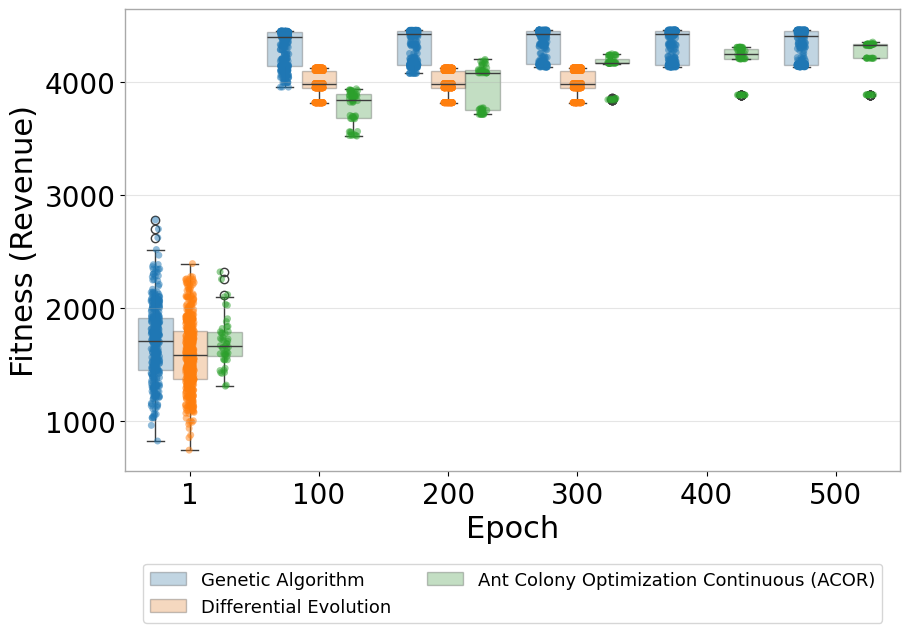

In [39]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 99, 199, 299, 399, 499])]

# Sum 1 to each value in 'Iteration' column
df_boxplot_filtered['Iteration'] = df_boxplot_filtered['Iteration'] + 1

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../../reports/mealpy/scattered_boxplot_top_3_25_opti_new.pdf'))

In [40]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU5,RU3,RU1,RU4,RU2
23,Genetic Algorithm,4,4457.33,174.37,19,27.0,19.0,33.33 %,71.43 %,80.0 %,80.0 %,100.0 %
20,Genetic Algorithm,1,4455.60,175.23,18,18.0,7.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
22,Genetic Algorithm,3,4448.94,174.59,18,18.0,11.0,33.33 %,71.43 %,60.0 %,80.0 %,100.0 %
24,Genetic Algorithm,5,4448.12,172.57,18,17.0,9.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
21,Genetic Algorithm,2,4448.12,175.70,18,17.0,9.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
3,Ant Colony Optimization Continuous (ACOR),4,4351.49,75.53,18,54.0,44.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
2,Ant Colony Optimization Continuous (ACOR),3,4335.49,75.96,17,54.0,27.0,33.33 %,71.43 %,40.0 %,100.0 %,80.0 %
4,Ant Colony Optimization Continuous (ACOR),5,4327.14,75.40,18,29.0,39.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
0,Ant Colony Optimization Continuous (ACOR),1,4211.83,75.56,18,46.0,67.0,33.33 %,71.43 %,40.0 %,100.0 %,100.0 %
15,Differential Evolution,1,4122.87,153.95,17,34.0,62.0,33.33 %,71.43 %,60.0 %,60.0 %,100.0 %


In [41]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrlllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU5 & RU3 & RU1 & RU4 & RU2 \\\\\n\\midrule\n23 & Genetic Algorithm & 4 & 4457.330000 & 174.370000 & 19 & 27.000000 & 19.000000 & 33.33 % & 71.43 % & 80.0 % & 80.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4455.600000 & 175.230000 & 18 & 18.000000 & 7.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4448.940000 & 174.590000 & 18 & 18.000000 & 11.000000 & 33.33 % & 71.43 % & 60.0 % & 80.0 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4448.120000 & 172.570000 & 18 & 17.000000 & 9.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n21 & Genetic Algorithm & 2 & 4448.120000 & 175.700000 & 18 & 17.000000 & 9.000000 & 33.33 % & 71.43 % & 40.0 % & 100.0 % & 100.0 % \\\\\n3 & Ant Colony Optimization Continuous (ACOR) & 4 & 4351.490000 & 75.530000 & 18 & 54.000000 & 44.000000 & 33.33 % & 

In [42]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.7508 s.
	Execution Time (by run) - Mean: 0.1502 s. - Std: 0.0016 s.
	Revenue - Mean: 4222.1675 - Std: 196.4983
	Scheduled Trains - Mean: 18.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 2.9903 s.
	Execution Time (by run) - Mean: 0.5981 s. - Std: 0.0085 s.
	Revenue - Mean: 3684.7437 - Std: 60.3932
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 3.8144 s.
	Execution Time (by run) - Mean: 0.7629 s. - Std: 0.068 s.
	Revenue - Mean: 3201.5653 - Std: 111.5301
	Scheduled Trains - Mean: 15.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 2.4812 s.


In [43]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,Algorithm,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Genetic Algorithm,174.49,1.20,4451.62,4.48,18,0
1,Ant Colony Optimization Continuous (ACOR),75.40,0.52,4222.17,196.50,18,1
2,Differential Evolution,150.40,2.14,3994.18,124.25,17,1
3,Particle Swarm Optimization,198.22,2.61,3818.86,165.93,16,1
4,Grey Wolf Optimizer,244.46,1.78,3713.27,104.76,17,1
5,Artificial Bee Colony,270.13,1.91,3684.74,60.39,17,1
6,Whale Optimization Algorithm,155.72,0.58,3561.12,35.53,15,0
7,Covariance Matrix Adaptation Evolution Strategy,211.11,11.22,3201.57,111.53,15,1
8,Simulated Annealing,223.75,2.05,3112.78,279.18,16,0
9,Hybrid Grey Wolf - Whale Optimization Algorithm,109.81,0.60,2916.05,60.51,16,0


In [44]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 174.490000 & 1.200000 & 4451.620000 & 4.480000 & 18 & 0 \\\\\n1 & Ant Colony Optimization Continuous (ACOR) & 75.400000 & 0.520000 & 4222.170000 & 196.500000 & 18 & 1 \\\\\n2 & Differential Evolution & 150.400000 & 2.140000 & 3994.180000 & 124.250000 & 17 & 1 \\\\\n3 & Particle Swarm Optimization & 198.220000 & 2.610000 & 3818.860000 & 165.930000 & 16 & 1 \\\\\n4 & Grey Wolf Optimizer & 244.460000 & 1.780000 & 3713.270000 & 104.760000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 270.130000 & 1.910000 & 3684.740000 & 60.390000 & 17 & 1 \\\\\n6 & Whale Optimization Algorithm & 155.720000 & 0.580000 & 3561.120000 & 35.530000 & 15 & 0 \\\\\n7 & Covariance Matrix Adaptation Evolution Strategy & 211.110000 & 11.220000 & 3201.570000 & 111.530000 

In [ ]:
df_history_copy = df_history.copy()

df_history['Iteration'] = df_history['Iteration'] + 1

sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves - Optimized hiperparameters",  # Título: Curvas de convergencia - Hiperparámetros optimizados
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 500),
              y_limit=(1500,4600),
              save_path=Path('../../reports/mealpy/mealpy_convergence_5_opti.pdf'),
              fig_size=(10, 9))

In [ ]:
top_3_algos = ("Genetic Algorithm",
               "Ant Colony Optimization Continuous (ACOR)",
               "Differential Evolution")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

df_history_top_3['Iteration'] = df_history_top_3['Iteration'] + 1

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves - Top 3 Algorithms, Optimized hiperparameters",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(0, 500),
              y_limit=(2100,4600),
              legend_type="",
              save_path=Path('../../reports/mealpy/mealpy_convergence_5_opti_top_3.pdf'),
              fig_size=(10, 7))

In [45]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2778.469051,0.356168,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1144, 867, 970, 1045, 902, 822, 9...",3.072932,0.000000,100.000000
1,1,Genetic Algorithm,1,2977.993634,0.351336,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.584962,15.879618,84.120382
2,1,Genetic Algorithm,2,3073.698401,0.353290,"[False, True, False, True, True, True, True, F...","[1070, 1109, 1147, 867, 970, 1045, 902, 822, 9...",2.122055,30.943642,69.056358
3,1,Genetic Algorithm,3,3193.633384,0.364052,"[False, True, False, True, True, True, True, F...","[1069, 1109, 1147, 864, 970, 1046, 909, 827, 9...",2.071679,32.582987,67.417013
4,1,Genetic Algorithm,4,3316.756348,0.365398,"[False, True, False, True, True, True, True, F...","[1069, 1117, 1143, 864, 970, 1051, 909, 827, 9...",1.875689,38.960933,61.039067


In [46]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [47]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2778.46905093509,
 2977.9936336105084,
 3554.1684176824374,
 3554.1684176824374,
 3700.8909050137577,
 3700.8909050137577,
 3744.353452738898,
 3776.9333461347073,
 3795.293845024511,
 3818.237566932447,
 3842.1754311728414,
 3877.27510630918,
 3924.967209460087,
 3934.849488397371,
 3984.2042819510234,
 3992.809442642085,
 4077.753878247852,
 4077.753878247852,
 4087.10261544371,
 4133.868059583853,
 4142.63941422933,
 4171.924859232169,
 4177.537762703141,
 4191.924661659567,
 4196.719345118499,
 4217.366987559271,
 4217.366987559271,
 4224.544467861591,
 4241.403216671121,
 4241.403216671121,
 4249.547477320572,
 4259.744674474781,
 4261.230942471745,
 4283.996349211392,
 4285.312300425874,
 4294.193546365601,
 4297.623180381389,
 4308.361814619004,
 4308.361814619004,
 4312.82995929789,
 4334.297389921357,
 4339.875365158933,
 4346.965030891406,
 4348.75661109866,
 4351.433175570292,
 4352.685497608724,
 4354.848722625164,
 4356.790796853056,
 4356.790796853056,
 4359.860033564903

In [48]:
print(len(algo_vals))

500


In [49]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [50]:
print(len(algo_vals))

900


In [51]:
def recortar_listas(lista1, lista2):
    # Convertir a arrays de numpy
    arr1 = np.array(lista1)
    arr2 = np.array(lista2)
    
    # Encontrar índices donde aparecen np.nan
    nan_idx1 = np.where(np.isnan(arr1))[0]
    nan_idx2 = np.where(np.isnan(arr2))[0]
    
    # Determinar la posición mínima de np.nan
    min_idx = min(
        nan_idx1[0] if len(nan_idx1) > 0 else len(arr1),
        nan_idx2[0] if len(nan_idx2) > 0 else len(arr2)
    )
    
    # Recortar las listas
    return arr1[:min_idx].tolist(), arr2[:min_idx].tolist()

# Ejemplo de uso
lista1 = [1.0, 2, 3, 4]
lista2 = [5, 6, np.nan, np.nan]

recortada1, recortada2 = recortar_listas(lista1, lista2)
print(recortada1, recortada2)

[1.0, 2.0] [5.0, 6.0]


In [52]:
# Confusion Matrix stadistical differences 

N = 50
from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

def get_run_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    algo_vals = algo_df.groupby(['Run'])['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_run_best_fitness(df_history, algo_name)
        algo_2_vals = get_run_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.kstest(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:394: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return hypotest_fun_in(*args, **kwds)


In [53]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    1.0   
Simulated Annealing                                            1.0   
Differential Evolution                                         1.0   
Ant Colony Optimization Continuous (ACOR)                      1.0   
Covariance Matrix Adaptation Evolution Strategy                1.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            1.0   
Whale Optimization Algorithm                                   1.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                1.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        1.0   
Particle Swarm Optimization                          

In [54]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                  0.008   
Simulated Annealing                                          0.008   
Differential Evolution                                       0.008   
Ant Colony Optimization Continuous (ACOR)                    0.008   
Covariance Matrix Adaptation Evolution Strategy              0.008   
Artificial Bee Colony                                        0.008   
Grey Wolf Optimizer                                          0.008   
Whale Optimization Algorithm                                 0.008   
Hybrid Grey Wolf - Whale Optimization Algorithm              0.008   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.008   
Particle Swarm Optimization                          

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed_opti_df_history.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', vmin=0, vmax=1, interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed_opti_df_history.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

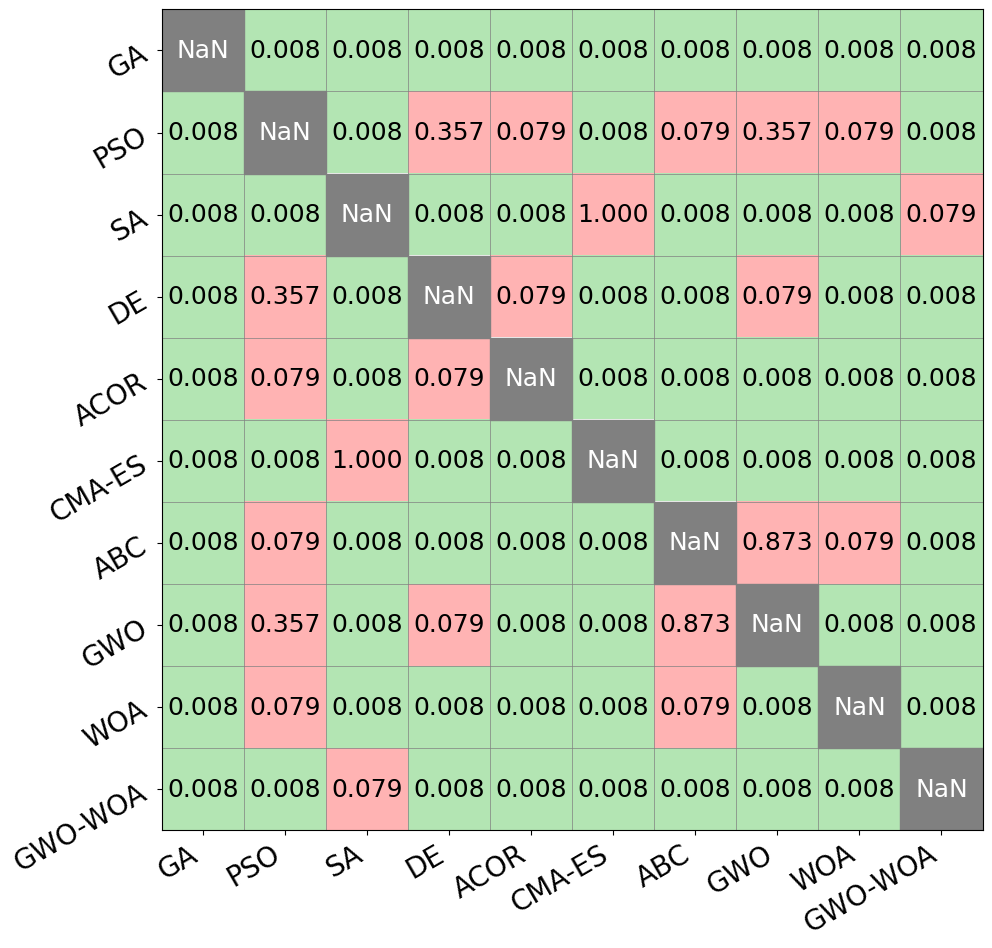

In [56]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

cmap = colors.ListedColormap(['#b3e5b3', '#ffb3b3'])
bounds = [0, 0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

names = ["GA", "PSO", "SA", "DE", "ACOR", "CMA-ES", "ABC", "GWO", "WOA", "GWO-WOA"]
plt.figure(figsize=(10, 10))
plt.imshow(df_p_values, cmap=cmap, norm=norm, interpolation='nearest')
# plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), names, rotation=30, ha='right', fontsize=20)
plt.yticks(range(df_p_values.shape[0]), names, rotation=30, fontsize=20)
#plt.title('Algorithm Pairwise Comparison: p-Values', fontweight='bold', fontsize=30)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=18)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved_opti_df_history.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

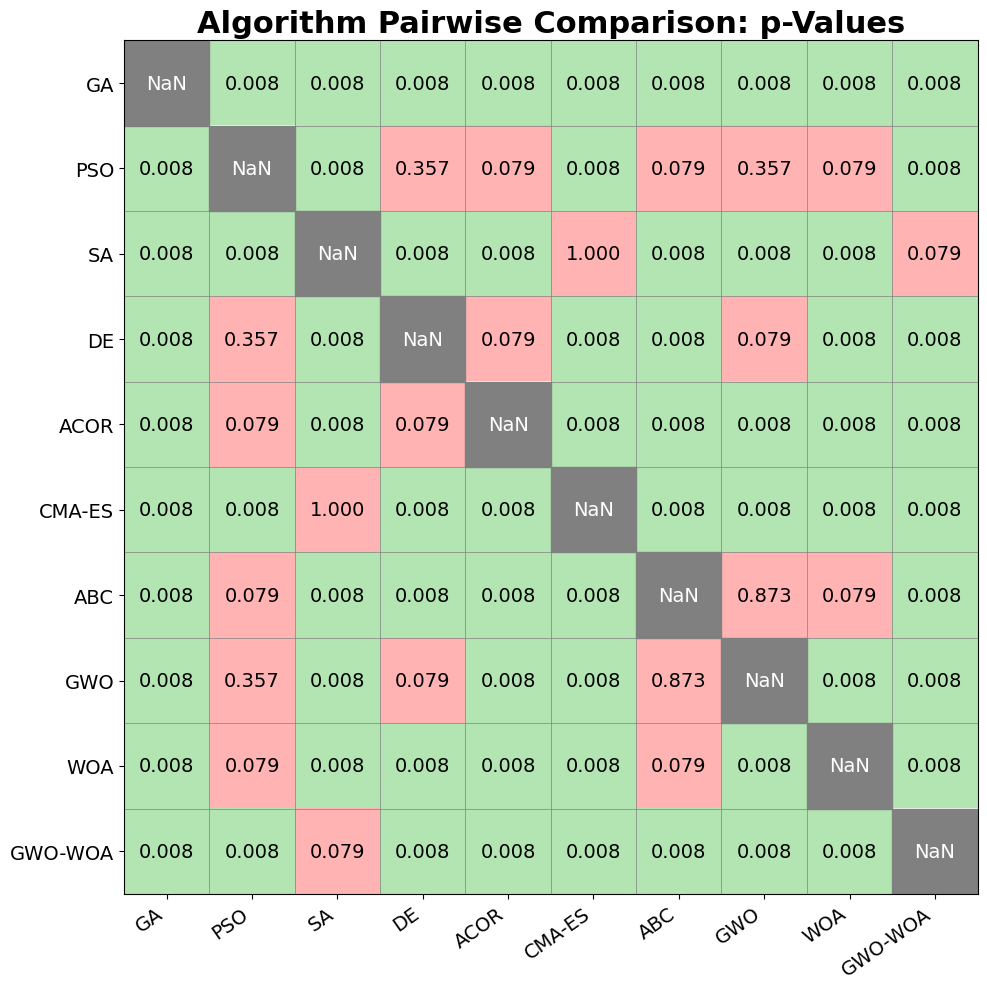

In [55]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

cmap = colors.ListedColormap(['#b3e5b3', '#ffb3b3'])
bounds = [0, 0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

names = ["GA", "PSO", "SA", "DE", "ACOR", "CMA-ES", "ABC", "GWO", "WOA", "GWO-WOA"]
plt.figure(figsize=(10, 10))
plt.imshow(df_p_values, cmap=cmap, norm=norm, interpolation='nearest')
# plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), names, rotation=35, ha='right', fontsize=14)
plt.yticks(range(df_p_values.shape[0]), names, fontsize=14)
plt.title('Algorithm Pairwise Comparison: p-Values', fontweight='bold', fontsize=22)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black'

        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=14)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved_opti_df_history.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# Confusion Matrix stadistical differences

N = 50
from scipy import stats

def get_run_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    algo_vals = algo_df.groupby(['Run'])['Fitness'].max().tolist()
    print(algo_vals)
    return algo_vals

row_ks = {}
row_p_values = {}
for algo_name, algo in mp_algos.items():
    algo_1_vals = get_run_best_fitness(df_history_old, algo_name)
    algo_2_vals = get_run_best_fitness(df_history, algo_name)
    stat, p_value = stats.kstest(algo_1_vals, algo_2_vals)
    row_ks[algo_name] = round(stat)
    row_p_values[algo_name] = round(p_value, 3)

print(row_p_values)

In [57]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 4
iteration = 499

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1057 1110 1147  872  970 1044  913  827  912 1354  731  130  210  271
  483  531  630  692  919  748  176  398  467  507  939  968 1038 1094
 1132 1161 1188 1253 1311 1347  413  466  501  277  334  372  535  577
 1071 1190 1249 1288  559  613  649 1241  462  525  567 1278  897  997
 1059], Discrete: [False  True False  True  True  True  True False  True False  True  True
 False  True  True  True  True False  True  True  True  True  True  True
  True]


In [58]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_opti'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(output_path=f'{supply_save_path}/{tt_file_name}.yml')

../../configs/mealpy/ supply_config_opti


In [60]:
final_supply = Supply.from_yaml(f'{supply_save_path}/{tt_file_name}.yml')

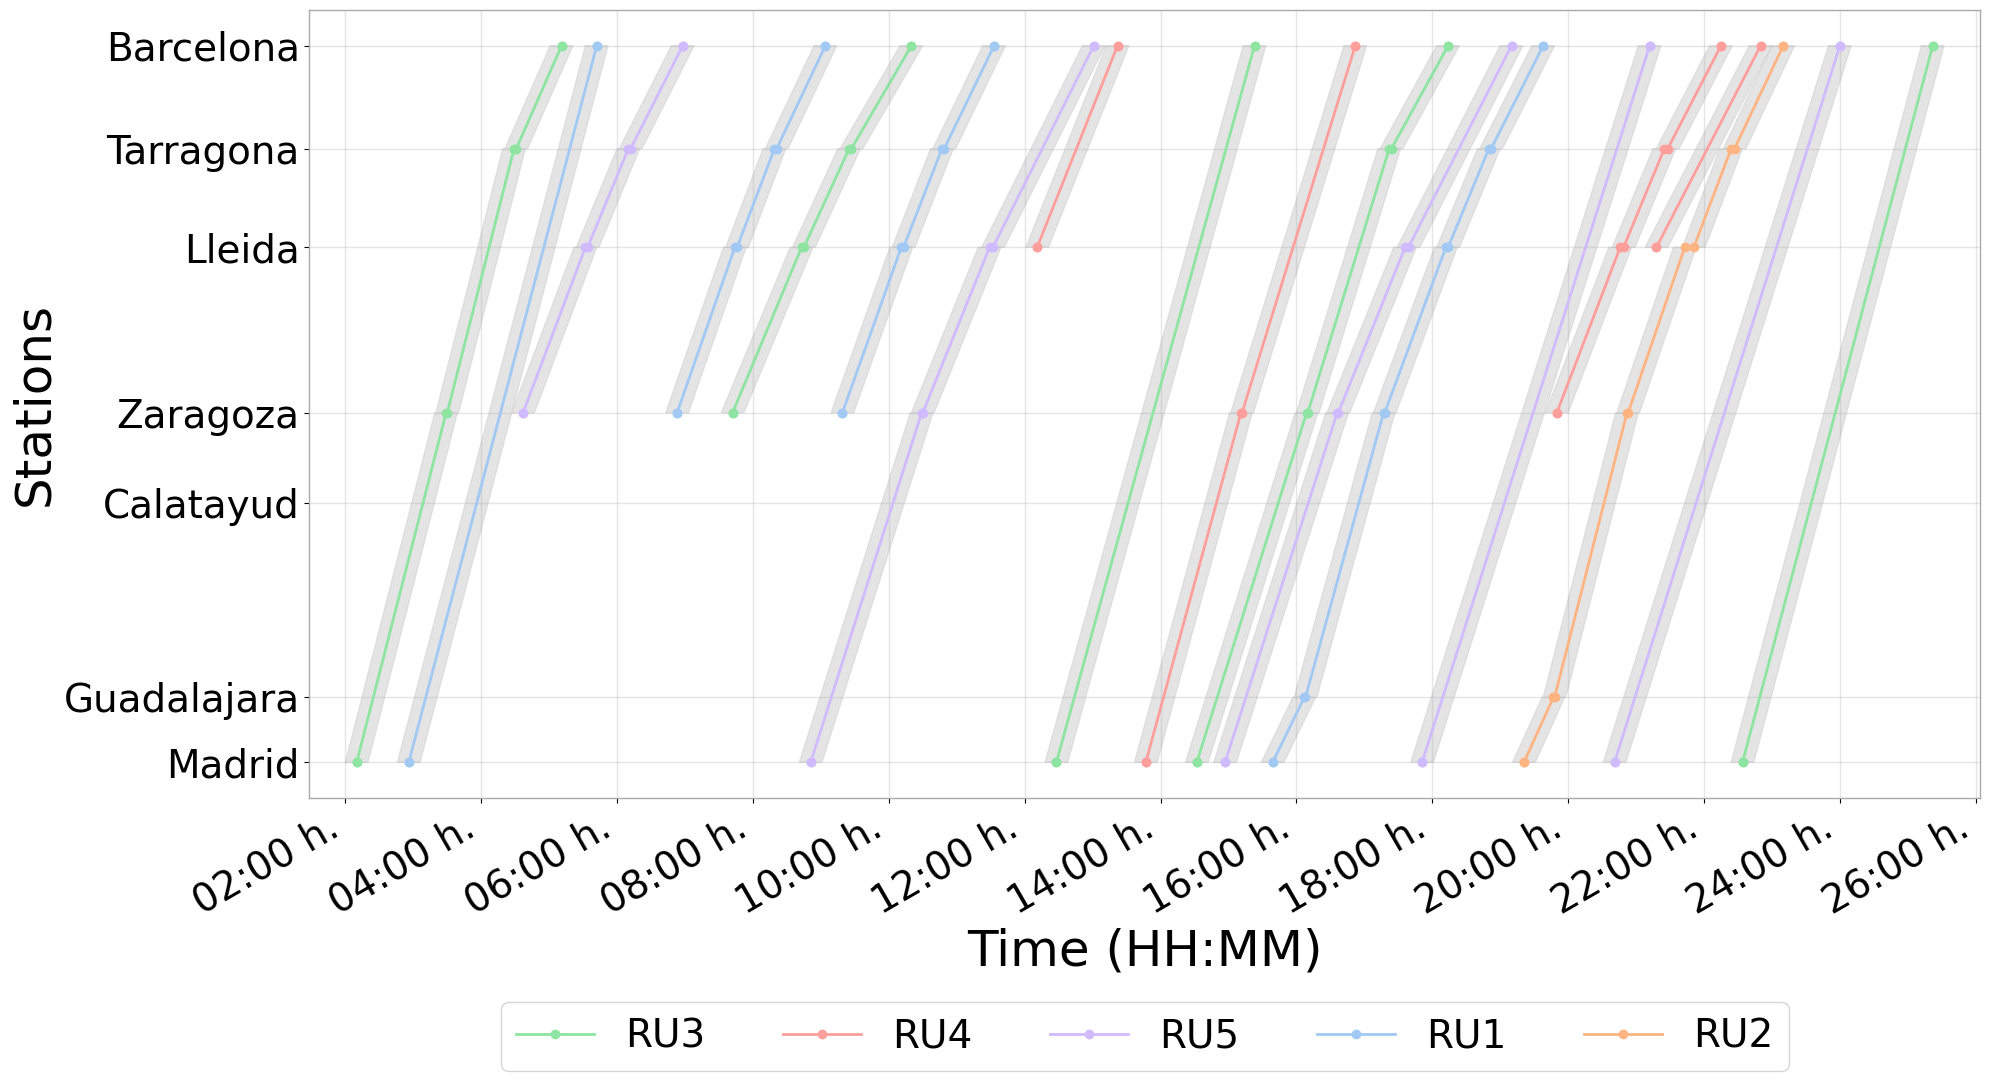

In [61]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=final_supply,
    date=date,
    save_path='../figures/'
)